In [11]:
import numpy as np
import os,sys


sys.path.append('../..')
sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/AAS_TEST/RUN/AAS-18-290_6DOF_manuscript/Run/Run_4km_terminal


In [12]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Load Policy

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Reward_terminal
queue fixed
Flat Constraint
Attitude Constraint


<IPython.core.display.Javascript object>


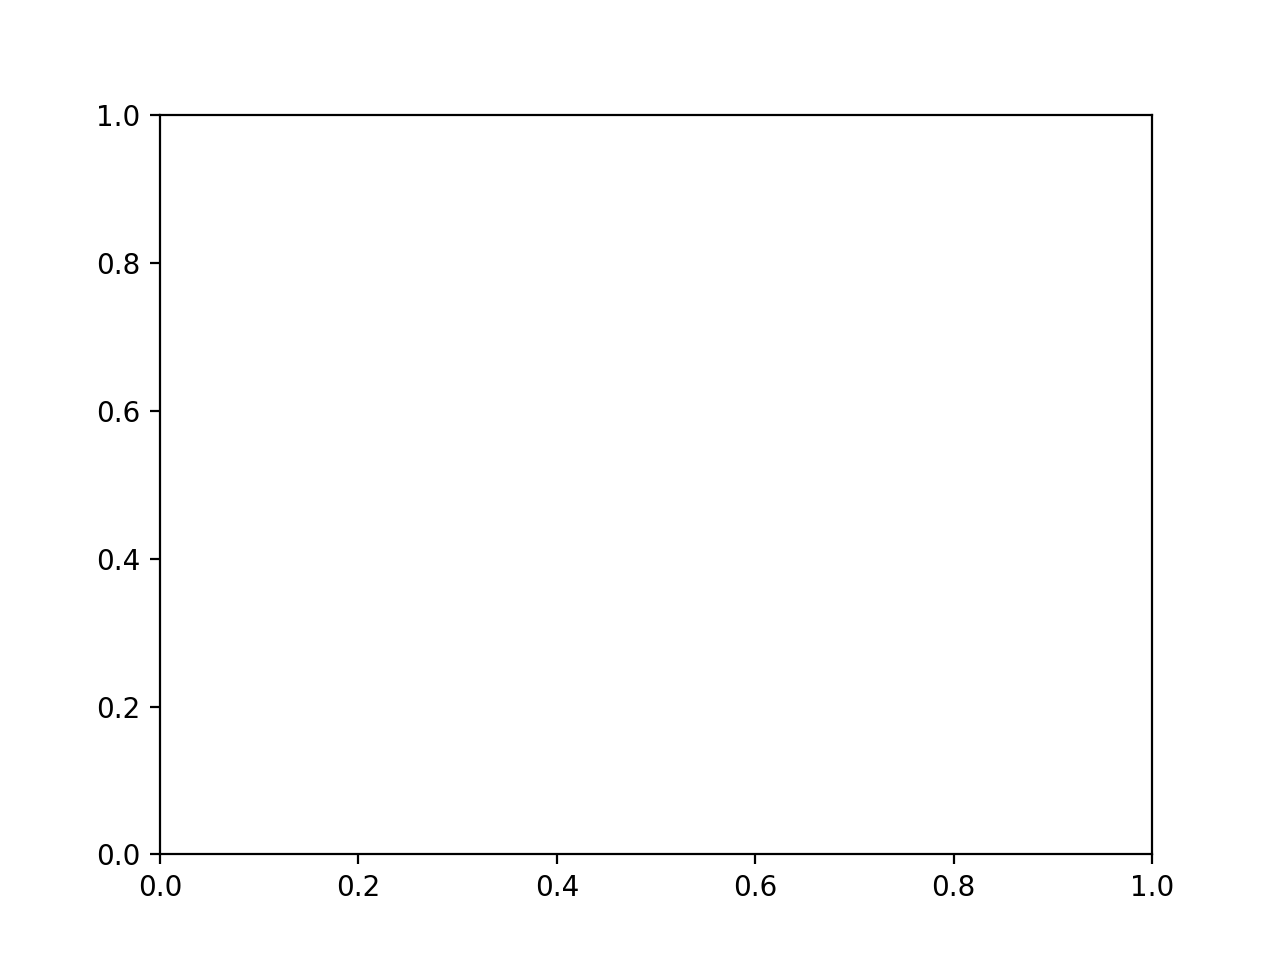

<IPython.core.display.Javascript object>


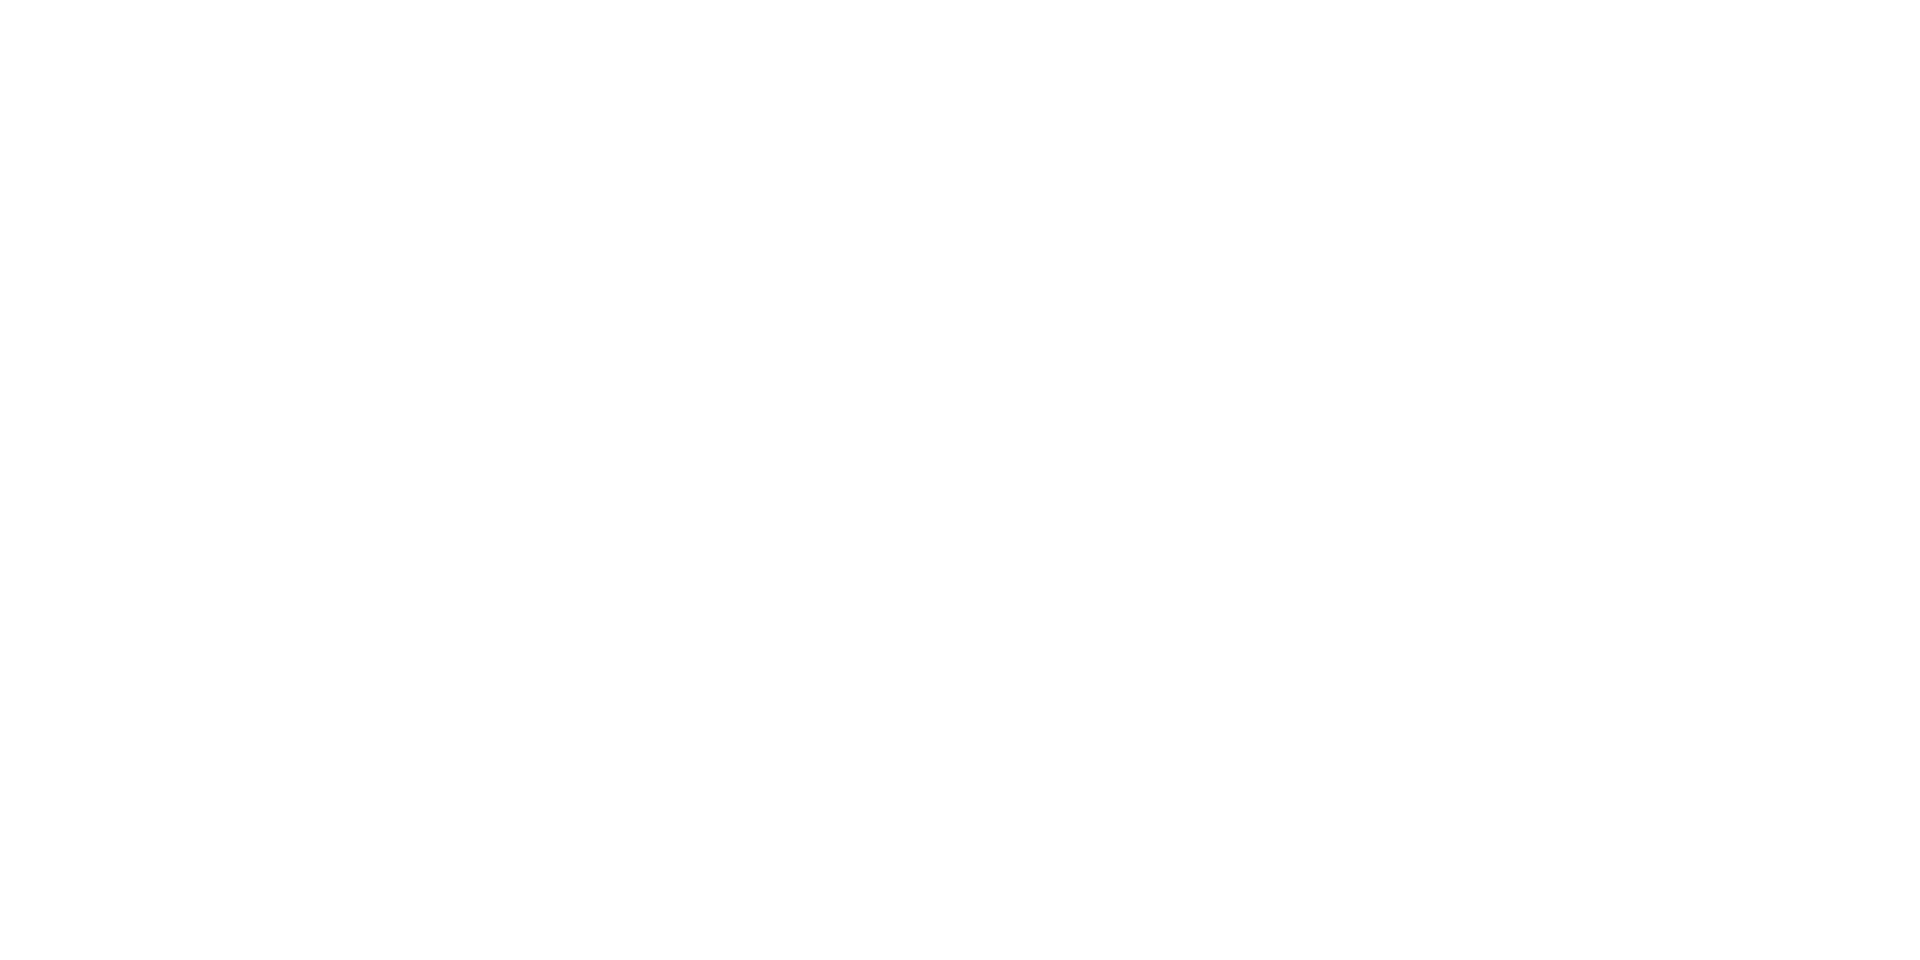

<IPython.core.display.Javascript object>


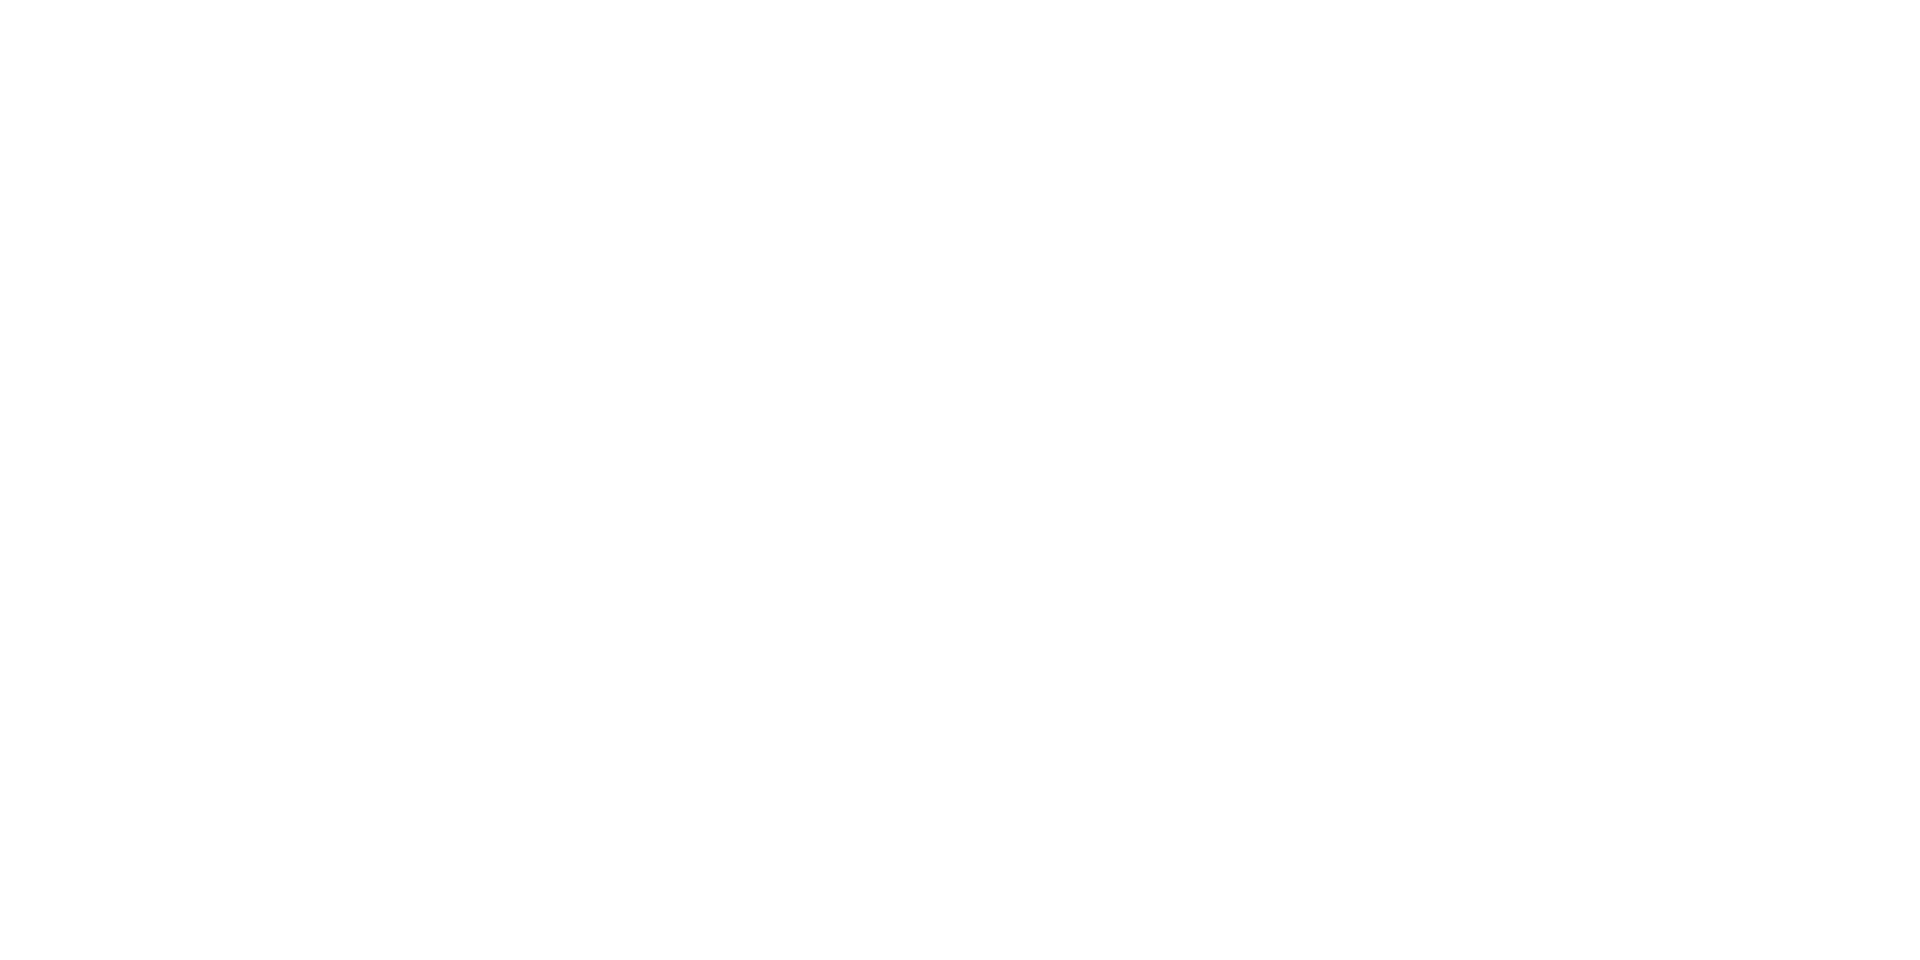

<IPython.core.display.Javascript object>


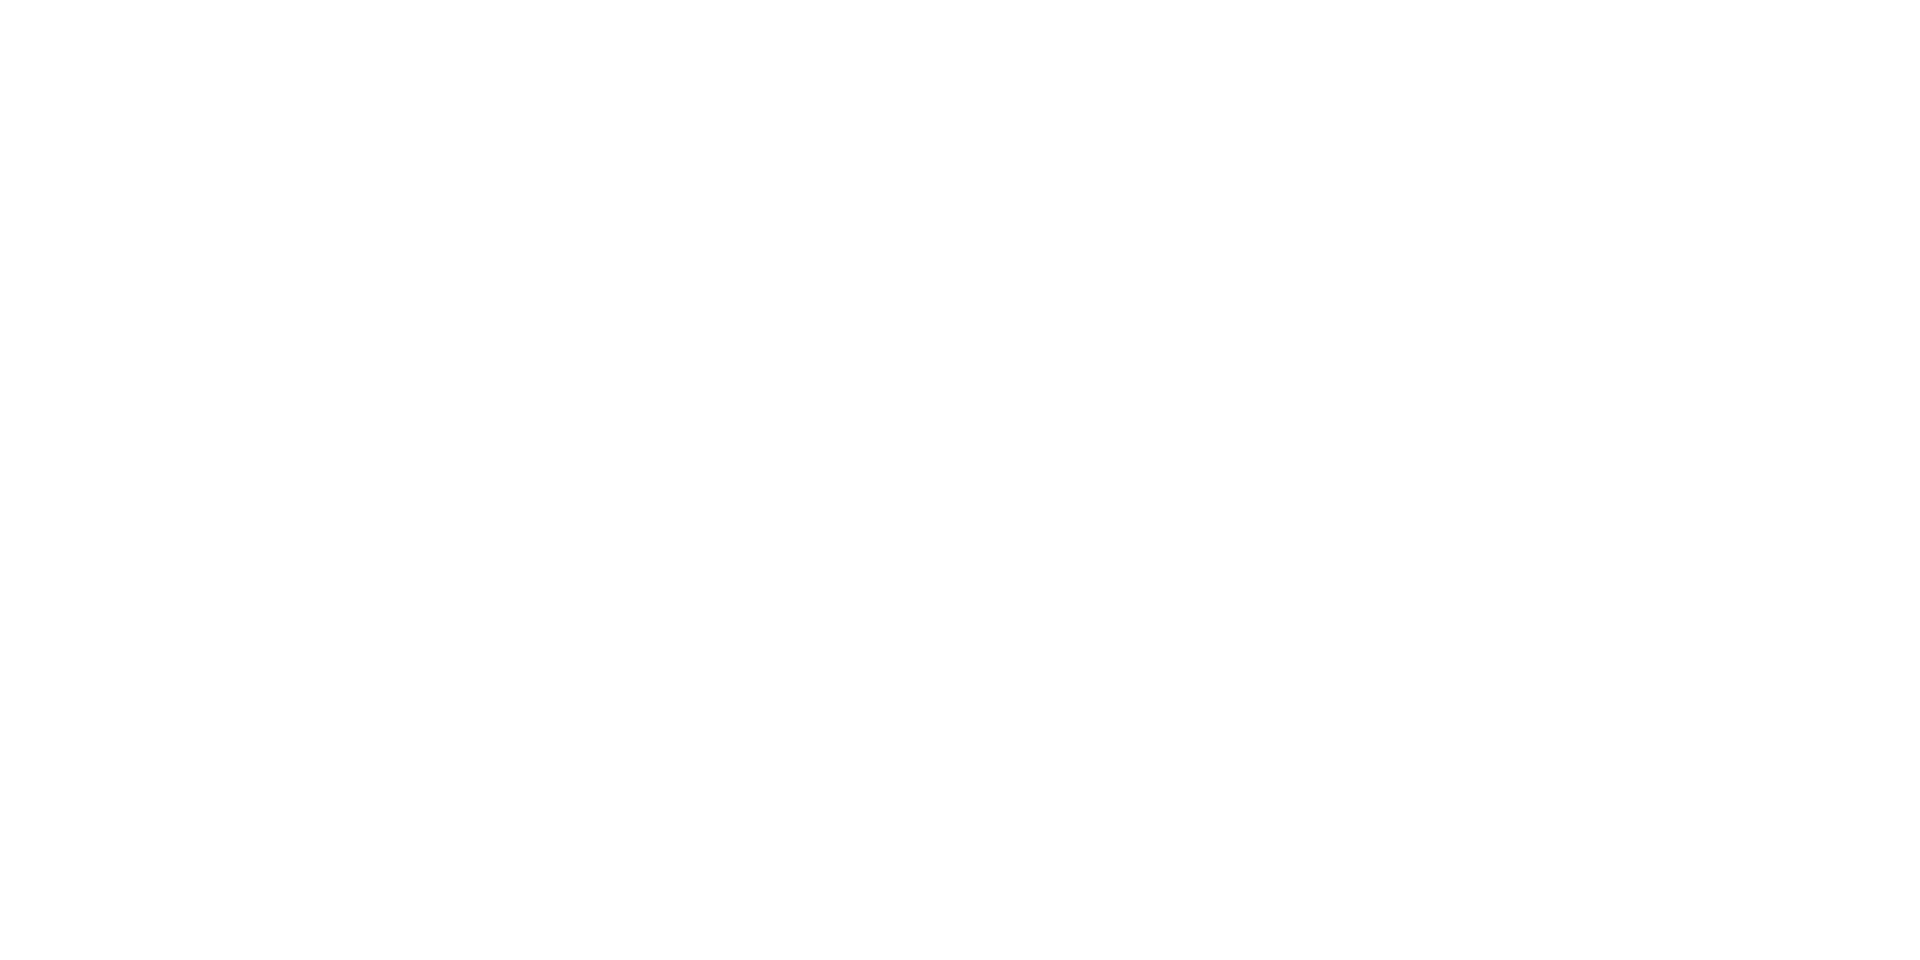

<IPython.core.display.Javascript object>


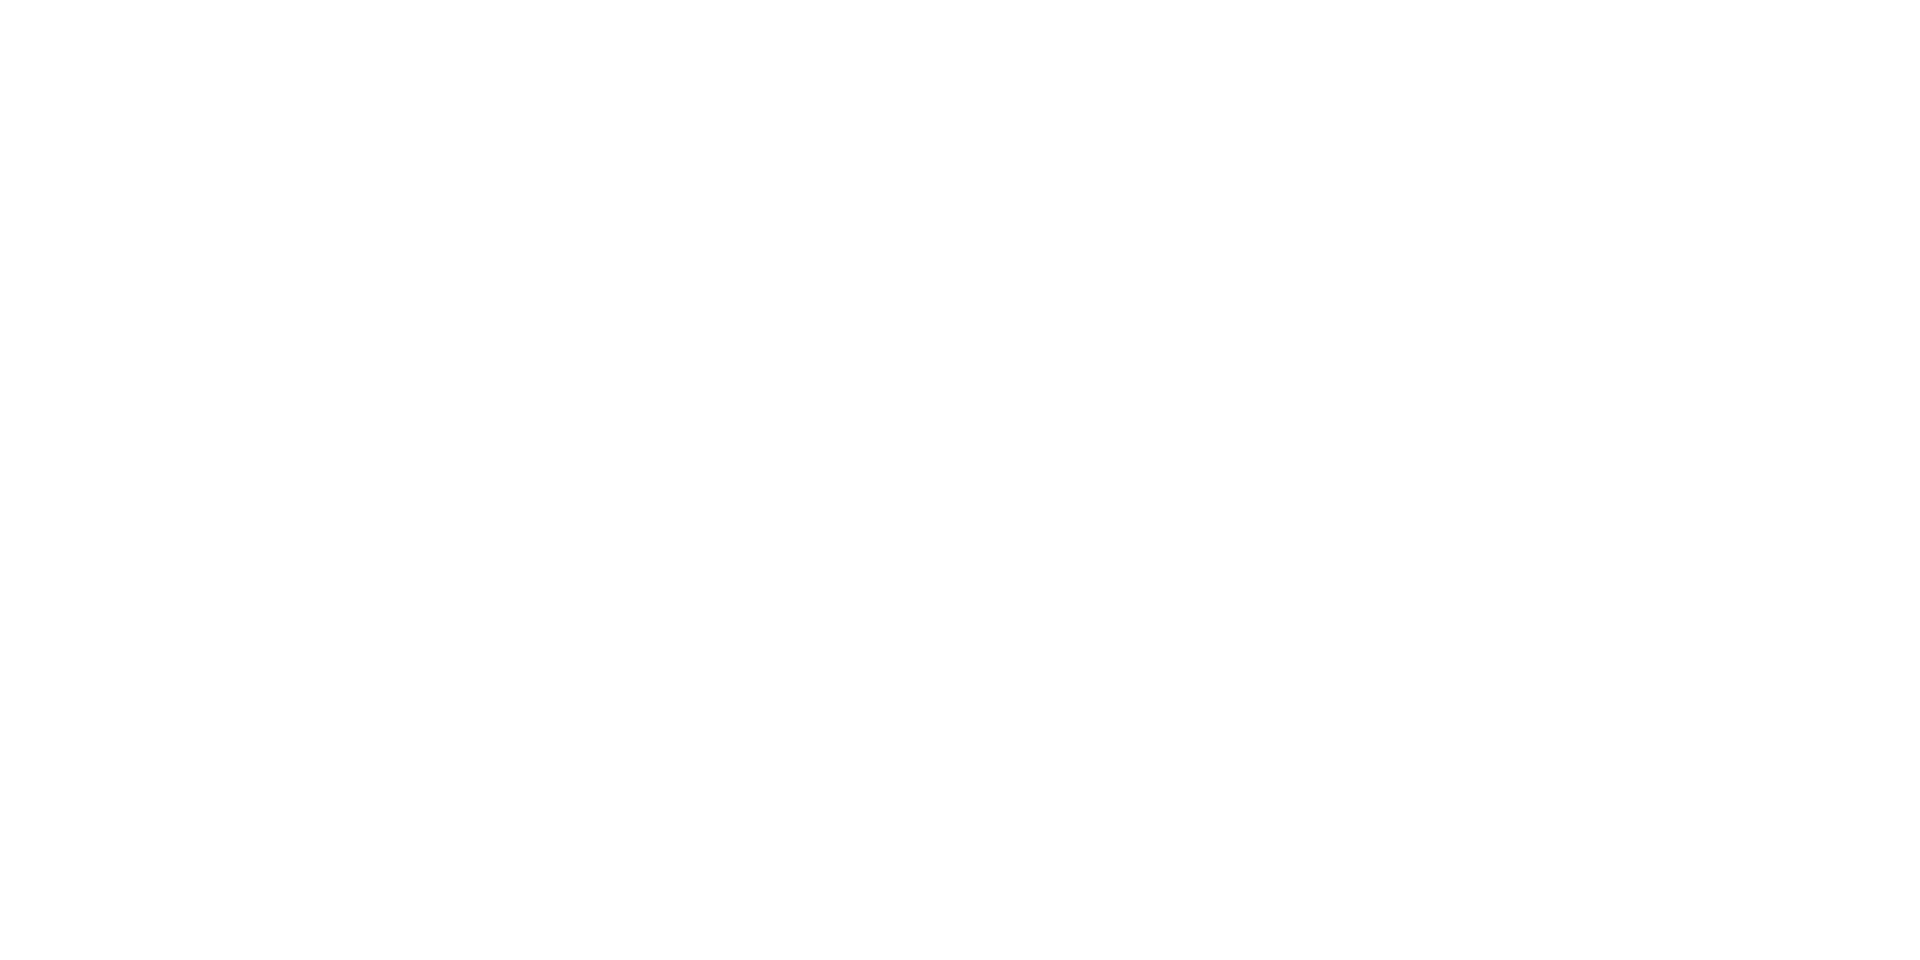

<IPython.core.display.Javascript object>


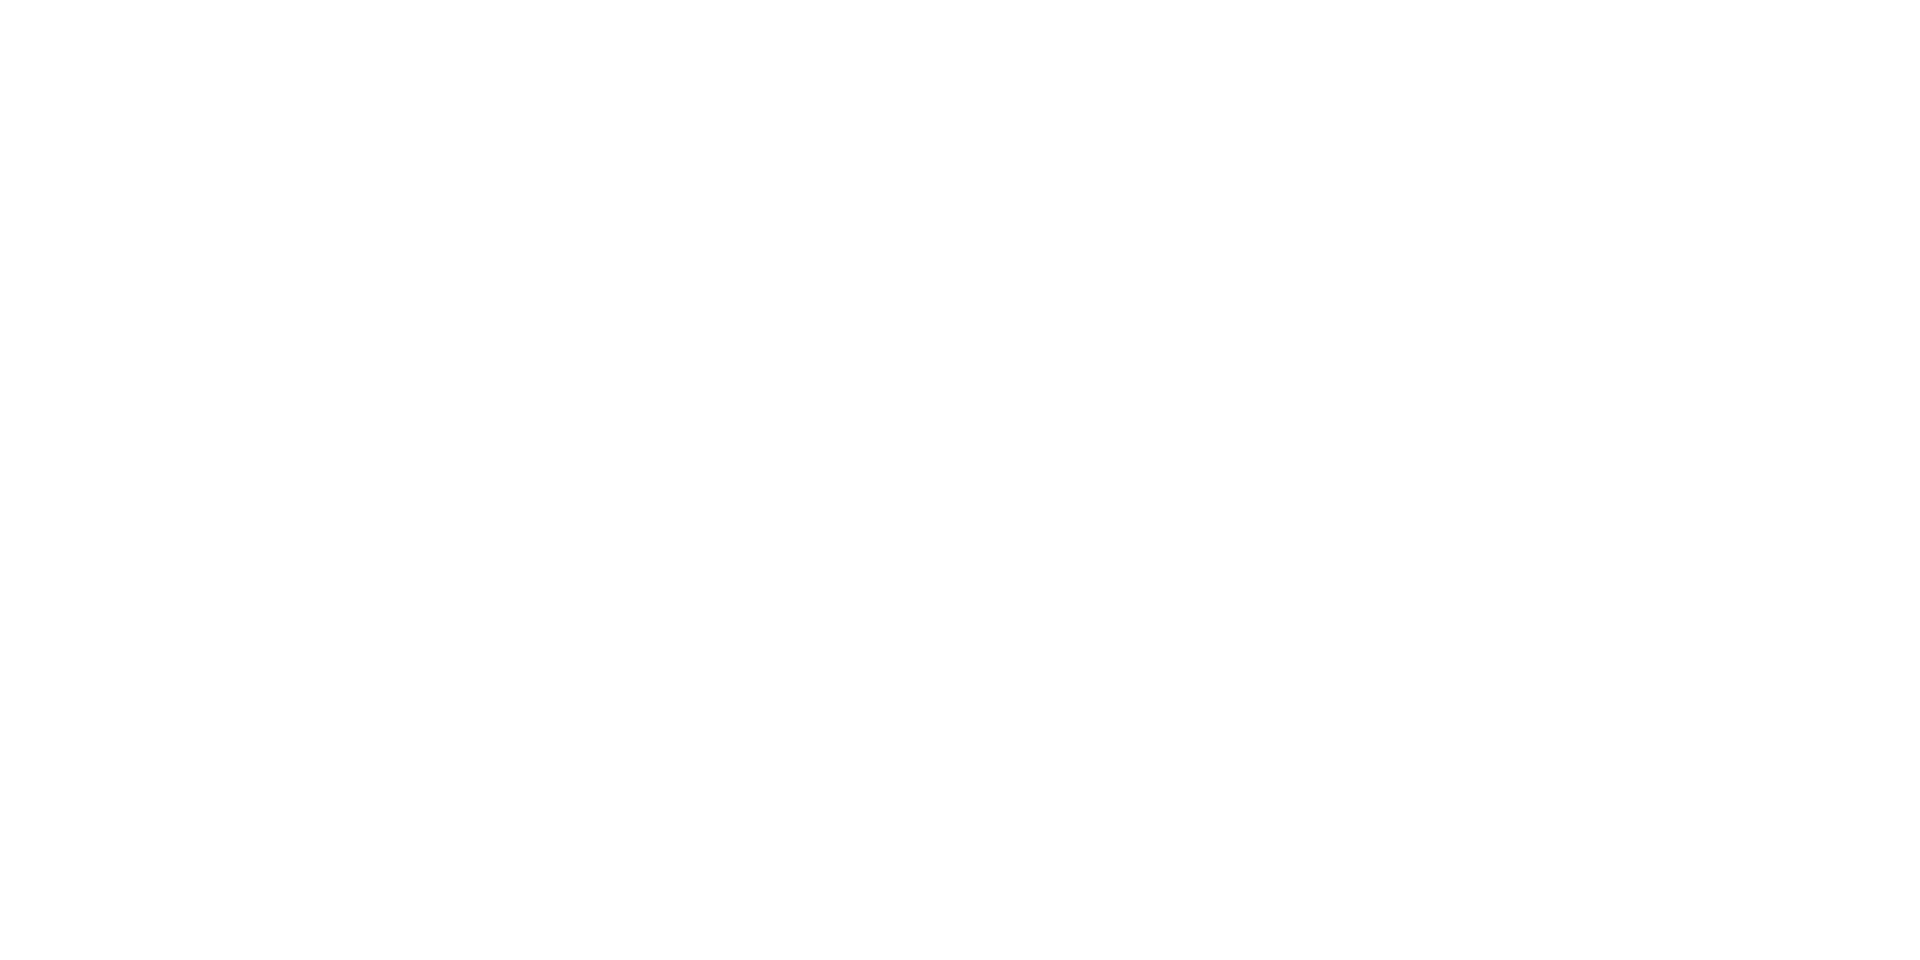

<IPython.core.display.Javascript object>


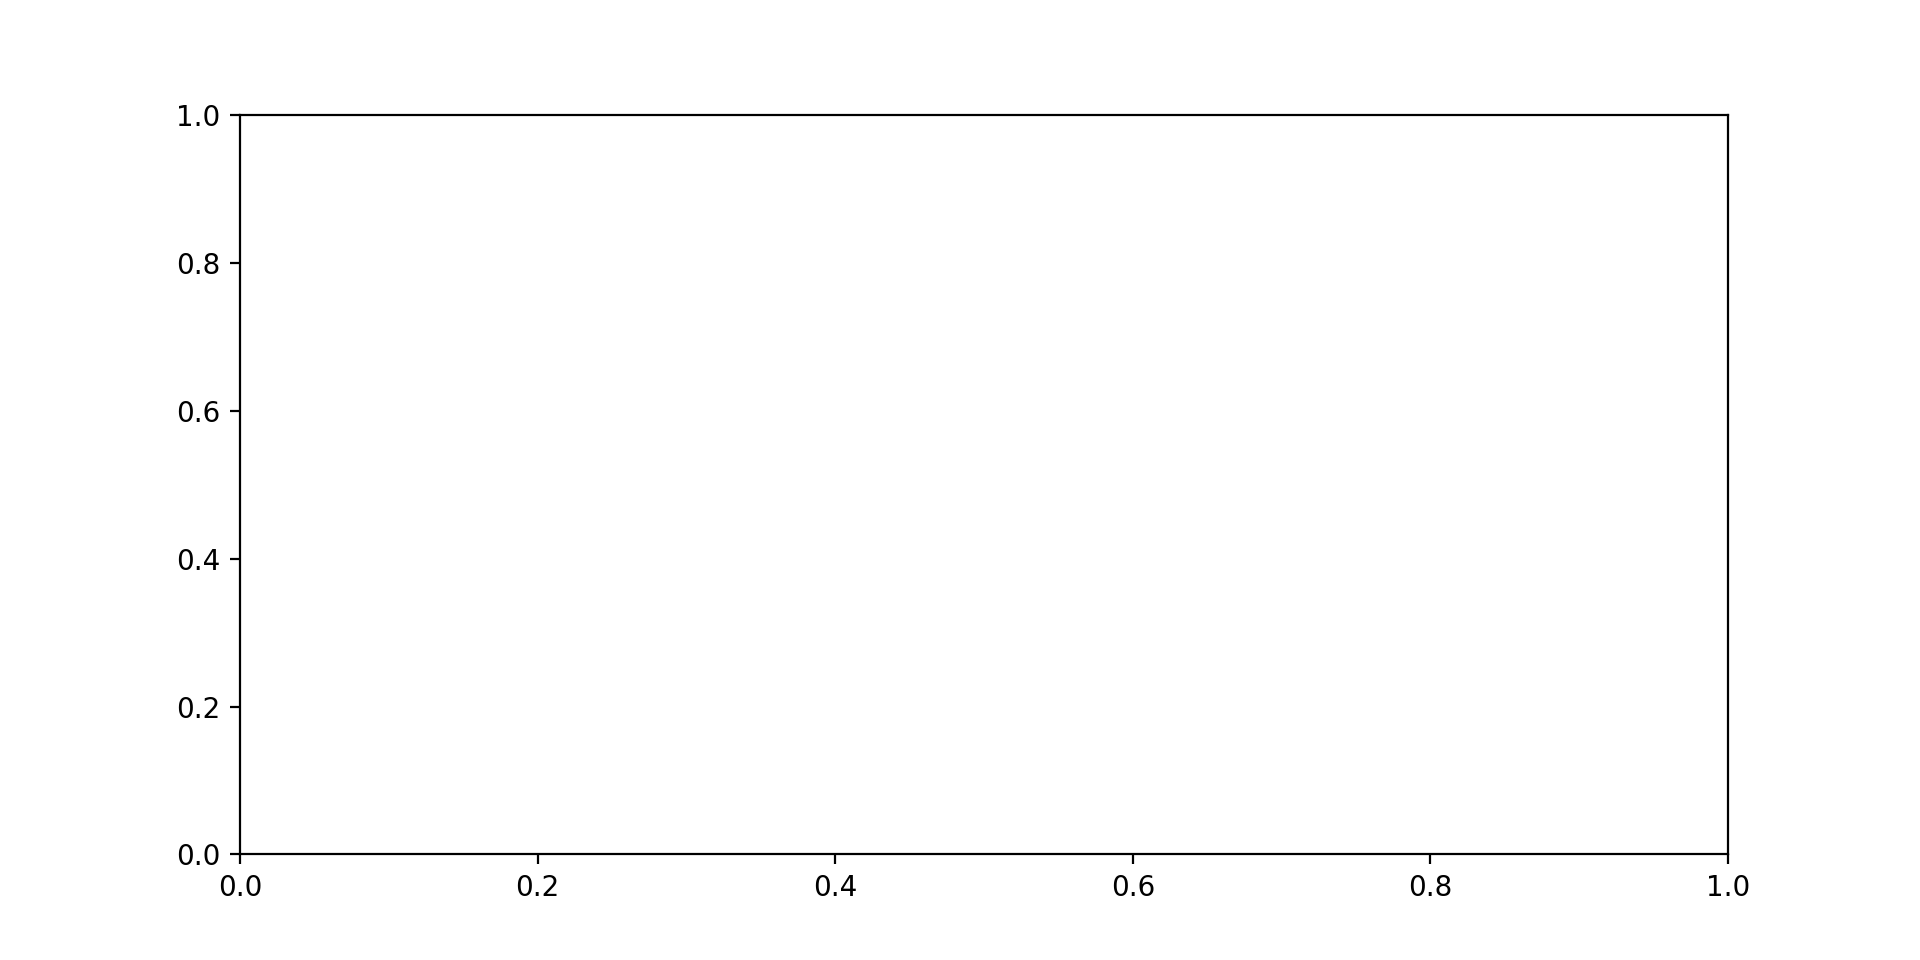

lander env att 2 fixed
Landing_icgen:
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
PPO Policy 1
Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8
[[-1.]
 [ 0.]
 [ 1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['h3/kernel:0', 'means/bias:0', 'means/kernel:0', 'logvars:0', 'h1/bias:0', 'h2/kernel:0', 'h1/kernel:0', 'h3/bias:0', 'h2/bias:0'])


In [13]:
from env_mdr import Env
from reward_terminal_mdr  import Reward
import env_utils as envu
import attitude_utils as attu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
from agent_mdr2 import Agent
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from attitude_constraint import Attitude_constraint
from thruster_model import Thruster_model

logger = Logger()
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Quaternion_attitude()

thruster_model = Thruster_model()
thruster_model.max_thrust = 5000
thruster_model.min_thrust = 1000

lander_model = Lander_model(thruster_model, attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=15., apf_tau2=100.)
lander_model.get_state_agent = lander_model.get_state_agent_tgo_alt

reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, fuel_coeff=-0.05, debug=False, landing_coeff=10.)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi/2-np.pi/16, np.pi/2-np.pi/16))
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=120.0,print_every=10)


env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.0,0.0), 
                           attitude_parameterization=attitude_parameterization,
                           l_offset=0.,
                           adapt_apf_v0=True,
                           inertia_uncertainty_diag=100.0, 
                           inertia_uncertainty_offdiag=10.0,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.01, 0.01),
                           roll  = (-np.pi/8, np.pi/8, -0.01, 0.01))

env.ic_gen.show()

obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True)
import utils
fname = "optimize_4km"
input_normalizer = utils.load_run(policy,fname)
print(input_normalizer)

# Test Policy over 4km

In [14]:
policy.test_mode=True
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2400,2600,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10164.38 |3292.38 |3464.10 |20000.00 |     5
glideslope | 4.077 | 7.645 | 1.028 |326.651 |    77
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |   500.3   500.3    -0.0 |     0.9     1.1     0.0 |   497.9   497.9    -0.1 |   502.4   503.6    -0.0
velocity |   0.043  -0.028  -0.946 |   0.012   0.019   0.042 |   0.005  -0.084  -1.112 |   0.066   0.037  -0.796
fuel     |310.87 | 12.32 |289.30 |348.55
attitude_321 |   0.032  -0.009  -0.003 |   0.112   0.005   0.007 |  -0.208  -0.021  -0.017 |   0.310   0.016   0.027
w        |  -0.002  -0.006  -0.000 |   0.016   0.012   0.000 |  -0.056  -0.053  -0.000 |   0.028   0.014   0.000
glideslope |  25.901 |  11.197 |  14.497 |  93.629
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10134.63 |3296.40 |3464.10 |20000.00 |     5
glideslope | 4.066 | 7.634 | 0.982 |326.651 |    77
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Fin

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |10181.67 |3284.99 |3464.10 |20000.00 |   530
glideslope | 4.212 | 9.725 | 0.960 |3295.093 |   967
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |   500.4   500.3    -0.0 |     0.9     1.1     0.0 |   497.8   496.8    -0.1 |   502.6   503.6    -0.0
velocity |   0.042  -0.029  -0.947 |   0.013   0.018   0.045 |  -0.023  -0.093  -1.183 |   0.073   0.037  -0.731
fuel     |309.87 | 12.28 |275.74 |350.03
attitude_321 |   0.039  -0.009  -0.003 |   0.108   0.005   0.007 |  -0.215  -0.027  -0.022 |   0.420   0.020   0.027
w        |  -0.002  -0.005  -0.000 |   0.015   0.010   0.000 |  -0.066  -0.053  -0.000 |   0.038   0.022   0.000
glideslope |  26.440 |  27.830 |  12.754 | 838.421
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |10185.62 |3285.67 |3464.10 |20000.00 |   530
glideslope | 4.297 |10.969 | 0.960 |3295.093 |   967
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |10188.79 |3292.34 |3464.10 |20000.00 |   530
glideslope | 4.318 |41.431 | 0.943 |34097.994 |  2123
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |   500.4   500.2    -0.0 |     0.9     1.1     0.0 |   497.3   496.5    -0.1 |   502.6   504.2    -0.0
velocity |   0.042  -0.030  -0.946 |   0.013   0.018   0.048 |  -0.026  -0.124  -1.271 |   0.081   0.037  -0.505
fuel     |309.55 | 12.45 |275.74 |357.90
attitude_321 |   0.042  -0.009  -0.003 |   0.108   0.005   0.007 |  -0.231  -0.027  -0.022 |   0.420   0.025   0.027
w        |  -0.002  -0.004  -0.000 |   0.016   0.010   0.000 |  -0.085  -0.053  -0.000 |   0.061   0.022   0.000
glideslope |  25.899 |  21.640 |  11.971 | 838.421
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |10188.46 |3292.09 |3464.10 |20000.00 |   530
glideslope | 4.304 |40.585 | 0.938 |34097.994 |  2123
sc_margin |100.000 | 0.000 |100.000 |100.000 |     

i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |10183.17 |3292.80 |3464.10 |20000.00 |  2616
glideslope | 4.220 |34.333 | 0.930 |34097.994 |  2123
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |   500.4   500.2    -0.0 |     0.9     1.1     0.0 |   497.3   496.4    -0.1 |   502.8   504.2    -0.0
velocity |   0.042  -0.030  -0.946 |   0.014   0.018   0.047 |  -0.045  -0.124  -1.290 |   0.081   0.037  -0.505
fuel     |309.61 | 12.55 |275.74 |357.90
attitude_321 |   0.042  -0.009  -0.004 |   0.108   0.005   0.007 |  -0.231  -0.029  -0.022 |   0.449   0.025   0.027
w        |  -0.002  -0.004  -0.000 |   0.016   0.010   0.000 |  -0.085  -0.053  -0.000 |   0.061   0.022   0.000
glideslope |  25.867 |  20.525 |  11.971 | 838.421
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |10182.20 |3293.55 |3464.10 |20000.00 |  2616
glideslope | 4.219 |33.864 | 0.930 |34097.994 |  2123
sc_margin |100.000 | 0.000 |100.000 |100.000 |     

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |10183.47 |3290.70 |3464.10 |20000.00 |  2616
glideslope | 4.197 |30.179 | 0.886 |34097.994 |  2123
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |   500.3   500.2    -0.0 |     0.9     1.1     0.0 |   497.3   496.4    -0.1 |   502.8   504.3    -0.0
velocity |   0.042  -0.030  -0.946 |   0.013   0.018   0.047 |  -0.045  -0.124  -1.296 |   0.081   0.037  -0.505
fuel     |309.59 | 12.46 |275.74 |357.90
attitude_321 |   0.041  -0.009  -0.004 |   0.107   0.005   0.007 |  -0.304  -0.029  -0.022 |   0.449   0.025   0.027
w        |  -0.002  -0.004  -0.000 |   0.016   0.010   0.000 |  -0.085  -0.053  -0.000 |   0.069   0.022   0.000
glideslope |  25.977 |  19.386 |  11.971 | 838.421
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |10183.08 |3289.65 |3464.10 |20000.00 |  2616
glideslope | 4.202 |29.871 | 0.886 |34097.994 |  2123
sc_margin |100.000 | 0.000 |100.000 |100.000 |     

In [ ]:
policy.close_sess()
